This notebook contains code for the conditional VAE for an image size of 128x128 and 256x256 from COCO. CLIP was used as the feature extractor and metrics shown are MSE, SSIM, and FID. Reconstructed images and generated images are shown.

*This notebook loads in COCO Dataset

Disclaimer: ChatGPT was used to assist for plotting

## Installation

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install --upgrade torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-w9gicvzz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-w9gicvzz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=87098a4d3bc8bfafcd121d0057f9fd82af34754695d32952fc0fbb9908f780c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ektsd_1/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 25.6 MB/s eta 0:00:00


In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

try:
    model, preprocess = clip.load("ViT-B/32", device=device, jit=False)  # Set jit=False for better stability
    print("CLIP loaded successfully")
except Exception as e:
    print(f"Error loading CLIP: {e}")

Using device: cuda


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 75.9MiB/s]


CLIP loaded successfully


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pycocotools.coco import COCO
import requests
from tqdm import tqdm
import json
import clip
from typing import List, Union
import random
import zipfile
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CocoCaptions
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, Dataset

from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance

## Util functions

In [ ]:
def generate_from_text(model, text_prompt, device="cuda"):
    model.eval()
    with torch.no_grad():
        # Encode text with CLIP
        sentences = re.split(r'(?<=[.!?])\s+', text_prompt)
        text_embedding = model.encode_condition(sentences)
        text_embedding = text_embedding.to(device)

        # Sample from latent space
        z = torch.randn(1, model.latent_dim).to(device)

        # Generate image
        generated_img = model.decode(z, text_embedding)

        # Convert to displayable format
        generated_img = generated_img.squeeze(0).cpu().permute(1, 2, 0)

        # Plot
        plt.figure(figsize=(5, 10))
        plt.imshow(generated_img)
        plt.axis('off')
        plt.title(f'Generated image for: "{text_prompt}"')
        plt.show()

        return generated_img

## Downloading COCO

In [ ]:

def download_coco_subset(num_images=1000):
    os.makedirs('coco_images', exist_ok=True)
    os.makedirs('coco_annotations', exist_ok=True)

    annotation_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    if not os.path.exists('coco_annotations/captions_train2017.json'):
        print("Downloading annotations...")
        response = requests.get(annotation_url)
        with open('annotations.zip', 'wb') as f:
            f.write(response.content)

        with zipfile.ZipFile('annotations.zip', 'r') as zip_ref:
            zip_ref.extractall('coco_annotations')

    coco = COCO('/content/coco_annotations/annotations/captions_train2017.json')

    img_ids = coco.getImgIds()
    selected_ids = random.sample(img_ids, num_images)

    print(f"Downloading {num_images} images...")
    for img_id in tqdm(selected_ids):
        # Get image info
        img_info = coco.loadImgs(img_id)[0]
        img_url = img_info['coco_url']
        file_name = img_info['file_name']
        file_path = os.path.join('coco_images', file_name)

        if os.path.exists(file_path):
            continue

        try:
            response = requests.get(img_url)
            if response.status_code == 200:
                with open(file_path, 'wb') as f:
                    f.write(response.content)
        except Exception as e:
            print(f"Error downloading {file_name}: {e}")

    print("Download complete!")
    return 'coco_images', 'coco_annotations/captions_train2017.json'

image_dir, annotation_file = download_coco_subset(num_images=10000)

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


100%|██████████| 10000/10000 [1:10:57<00:00,  2.35it/s]

Download complete!


In [ ]:
def download_coco_val_subset(num_images=1000):
    os.makedirs('coco_images', exist_ok=True)
    os.makedirs('coco_annotations', exist_ok=True)

    annotation_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    if not os.path.exists('coco_annotations/captions_train2017.json'):
        print("Downloading annotations...")
        response = requests.get(annotation_url)
        with open('annotations.zip', 'wb') as f:
            f.write(response.content)

        with zipfile.ZipFile('annotations.zip', 'r') as zip_ref:
            zip_ref.extractall('coco_annotations')

    coco = COCO('/content/coco_annotations/annotations/captions_val2017.json')

    img_ids = coco.getImgIds()
    selected_ids = random.sample(img_ids, num_images)

    print(f"Downloading {num_images} images...")
    for img_id in tqdm(selected_ids):
        img_info = coco.loadImgs(img_id)[0]
        img_url = img_info['coco_url']
        file_name = img_info['file_name']
        file_path = os.path.join('coco_images', file_name)

        if os.path.exists(file_path):
            continue

        try:
            response = requests.get(img_url)
            if response.status_code == 200:
                with open(file_path, 'wb') as f:
                    f.write(response.content)
        except Exception as e:
            print(f"Error downloading {file_name}: {e}")

    print("Download complete!")
    return 'coco_images', 'coco_annotations/captions_val2017.json'

image_dir_val, annotation_file_val = download_coco_val_subset(num_images=1000)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


100%|██████████| 1000/1000 [07:02<00:00,  2.37it/s]

Download complete!


# For 128x128 CVAE

## Extract Features with CLIP and Dataset

In [ ]:
class COCODatasetWithClip(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotation_file)

        all_ids = list(self.coco.imgs.keys())
        self.ids = []
        for img_id in all_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            file_path = os.path.join(root_dir, img_info['file_name'])
            if os.path.exists(file_path):
                self.ids.append(img_id)

        print(f"Found {len(self.ids)} images in directory")

        print("Loading CLIP...")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.clip_model, _ = clip.load("ViT-B/32", device=device)
        self.clip_model.eval()

        print("Pre-encoding captions...")
        self.encoded_captions = {}
        for img_id in tqdm(self.ids):
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            captions = [ann['caption'] for ann in anns]

            with torch.no_grad():
                text_inputs = clip.tokenize(captions).to(device)
                text_features = self.clip_model.encode_text(text_inputs)
                # Convert to float32 before averaging
                text_features = text_features.float()
                avg_embedding = text_features.mean(dim=0)
                self.encoded_captions[img_id] = avg_embedding

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]

        img_info = self.coco.loadImgs(img_id)[0]
        image_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption_embedding = self.encoded_captions[img_id].float()

        return image, caption_embedding

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = COCODatasetWithClip(
    root_dir='coco_images',
    annotation_file='/content/coco_annotations/annotations/captions_train2017.json',
    transform=transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True)

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!
Found 10000 images in directory
Loading CLIP...
Pre-encoding captions...


100%|██████████| 10000/10000 [01:39<00:00, 100.10it/s]


In [ ]:
val_dataset = COCODatasetWithClip(
    root_dir='coco_images',
    annotation_file='/content/coco_annotations/annotations/captions_val2017.json',
    transform=transform
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=True)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Found 1000 images in directory
Loading CLIP...
Pre-encoding captions...


100%|██████████| 1000/1000 [00:09<00:00, 100.87it/s]


## Model Architecture

In [ ]:
class cVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.clip_model, _ = clip.load("ViT-B/32", device=device)
        self.clip_model.eval()
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.latent_dim = latent_dim

        # Modified encoder for 128x128 input
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )

        self.flatten_size = 512 * 4 * 4  # New flattened size

        self.condition_processor_encoder = nn.Sequential(
            nn.Linear(512, self.flatten_size)
        )

        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 512 * 4 * 4)

        self.condition_processor_decoder = nn.Sequential(
            nn.Linear(512, 512 * 4 * 4)
        )

        # Modified decoder for 128x128 output
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),  # 128x128
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, stride=1, padding=1),  # 128x128
            nn.Sigmoid()
        )

    def encode_condition(self, text):
        with torch.no_grad():
            embeddings = []
            for sentence in text:
                embeddings.append(self.clip_model.encode_text(clip.tokenize(sentence).to('cuda')).type(torch.float32))
            return torch.mean(torch.stack(embeddings), dim=0)

    def encode(self, x, c):
        x = self.encoder(x)
        c = self.condition_processor_encoder(c)
        x = x + c
        return self.fc_mu(x), self.fc_var(x)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z = self.decoder_input(z)
        z = z.view(-1, 512, 4, 4)
        c = self.condition_processor_decoder(c)
        c = c.view(-1, 512, 4, 4)
        z = z + c

        return self.decoder(z)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')  # Changed from binary_cross_entropy_with_logits
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

## Model Training

In [ ]:
def train_cvae(model, train_loader, num_epochs=100, learning_rate=1e-4, device="cuda"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    train_losses = []
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (images, captions) in enumerate(pbar):
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            recon_batch, mu, log_var = model(images, captions)

            loss = loss_function(recon_batch, images, mu, log_var)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'batch_loss': loss.item()})

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        scheduler.step(avg_epoch_loss)

        print(f'====> Epoch: {epoch + 1} Average loss: {avg_epoch_loss:.4f} Learning Rate: {learning_rate}')

        if epoch % 5 == 0:
          with torch.no_grad():
              recon_images, _, _ = model(images[:4], captions[:4])
              fig, axes = plt.subplots(1, 4, figsize=(12, 4))
              for i, ax in enumerate(axes):
                  ax.imshow(recon_images[i].permute(1, 2, 0).cpu().numpy(), interpolation='nearest')
                  ax.axis('off')
              plt.tight_layout()
              plt.show()

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'best_cvae_128_model.pth')

    return train_losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cVAE(latent_dim=512)
# model.load_state_dict(torch.load('/content/catcvae_2.pt'))
model.to(device)

losses = train_cvae(
    model=model,
    train_loader=train_dataloader,
    num_epochs=50,
    learning_rate=1e-3,
    device=device
)

Epoch 1/50: 100%|██████████| 40/40 [01:02<00:00,  1.57s/it, batch_loss=4.92e+5]


====> Epoch: 1 Average loss: 8008622.8766 Learning Rate: 0.001


Epoch 2/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.63e+5]


====> Epoch: 2 Average loss: 7437684.2844 Learning Rate: 0.001


Epoch 3/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=5.03e+5]


====> Epoch: 3 Average loss: 7316608.3852 Learning Rate: 0.001


Epoch 4/50: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it, batch_loss=4.66e+5]


====> Epoch: 4 Average loss: 7261026.0320 Learning Rate: 0.001


Epoch 5/50: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it, batch_loss=4.73e+5]


====> Epoch: 5 Average loss: 7233221.2188 Learning Rate: 0.001


Epoch 6/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.24e+5]


====> Epoch: 6 Average loss: 7202218.8609 Learning Rate: 0.001


Epoch 7/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.7e+5]


====> Epoch: 7 Average loss: 7170165.4469 Learning Rate: 0.001


Epoch 8/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.51e+5]


====> Epoch: 8 Average loss: 7139732.7555 Learning Rate: 0.001


Epoch 9/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.76e+5]


====> Epoch: 9 Average loss: 7075405.7750 Learning Rate: 0.001


Epoch 10/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.26e+5]


====> Epoch: 10 Average loss: 7023749.1102 Learning Rate: 0.001


Epoch 11/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.59e+5]


====> Epoch: 11 Average loss: 7005291.6820 Learning Rate: 0.001


Epoch 12/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.36e+5]


====> Epoch: 12 Average loss: 6987038.3969 Learning Rate: 0.001


Epoch 13/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.75e+5]


====> Epoch: 13 Average loss: 6969458.2961 Learning Rate: 0.001


Epoch 14/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.41e+5]


====> Epoch: 14 Average loss: 6962866.4805 Learning Rate: 0.001


Epoch 15/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.47e+5]


====> Epoch: 15 Average loss: 6946016.2359 Learning Rate: 0.001


Epoch 16/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.38e+5]


====> Epoch: 16 Average loss: 6943253.8055 Learning Rate: 0.001


Epoch 17/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.42e+5]


====> Epoch: 17 Average loss: 6929354.8414 Learning Rate: 0.001


Epoch 18/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.53e+5]


====> Epoch: 18 Average loss: 6919450.3516 Learning Rate: 0.001


Epoch 19/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.69e+5]


====> Epoch: 19 Average loss: 6914488.2500 Learning Rate: 0.001


Epoch 20/50: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it, batch_loss=4.87e+5]


====> Epoch: 20 Average loss: 6907327.6797 Learning Rate: 0.001


Epoch 21/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.32e+5]


====> Epoch: 21 Average loss: 6898391.8344 Learning Rate: 0.001


Epoch 22/50: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it, batch_loss=4.24e+5]


====> Epoch: 22 Average loss: 6891317.0242 Learning Rate: 0.001


Epoch 23/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.41e+5]


====> Epoch: 23 Average loss: 6886866.2945 Learning Rate: 0.001


Epoch 24/50: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it, batch_loss=4.54e+5]


====> Epoch: 24 Average loss: 6885798.3523 Learning Rate: 0.001


Epoch 25/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.29e+5]


====> Epoch: 25 Average loss: 6877168.7477 Learning Rate: 0.001


Epoch 26/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.32e+5]


====> Epoch: 26 Average loss: 6873582.2727 Learning Rate: 0.001


Epoch 27/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.41e+5]


====> Epoch: 27 Average loss: 6874227.9680 Learning Rate: 0.001


Epoch 28/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.26e+5]


====> Epoch: 28 Average loss: 6869568.9172 Learning Rate: 0.001


Epoch 29/50: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it, batch_loss=4.5e+5]


====> Epoch: 29 Average loss: 6874039.8625 Learning Rate: 0.001


Epoch 30/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.5e+5]


====> Epoch: 30 Average loss: 6861660.7078 Learning Rate: 0.001


Epoch 31/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.72e+5]


====> Epoch: 31 Average loss: 6855693.4672 Learning Rate: 0.001


Epoch 32/50: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it, batch_loss=4.73e+5]


====> Epoch: 32 Average loss: 6852193.2227 Learning Rate: 0.001


Epoch 33/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.22e+5]


====> Epoch: 33 Average loss: 6852212.5430 Learning Rate: 0.001


Epoch 34/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.55e+5]


====> Epoch: 34 Average loss: 6847208.2570 Learning Rate: 0.001


Epoch 35/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.4e+5]


====> Epoch: 35 Average loss: 6842637.7922 Learning Rate: 0.001


Epoch 36/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.39e+5]


====> Epoch: 36 Average loss: 6842539.8016 Learning Rate: 0.001


Epoch 37/50: 100%|██████████| 40/40 [01:01<00:00,  1.53s/it, batch_loss=4.55e+5]


====> Epoch: 37 Average loss: 6835007.2336 Learning Rate: 0.001


Epoch 38/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.46e+5]


====> Epoch: 38 Average loss: 6835358.7953 Learning Rate: 0.001


Epoch 39/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.16e+5]


====> Epoch: 39 Average loss: 6829924.8125 Learning Rate: 0.001


Epoch 40/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.05e+5]


====> Epoch: 40 Average loss: 6826270.9578 Learning Rate: 0.001


Epoch 41/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.25e+5]


====> Epoch: 41 Average loss: 6821159.6781 Learning Rate: 0.001


Epoch 42/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.52e+5]


====> Epoch: 42 Average loss: 6823651.7453 Learning Rate: 0.001


Epoch 43/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.29e+5]


====> Epoch: 43 Average loss: 6817543.6000 Learning Rate: 0.001


Epoch 44/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.28e+5]


====> Epoch: 44 Average loss: 6812906.1000 Learning Rate: 0.001


Epoch 45/50: 100%|██████████| 40/40 [01:00<00:00,  1.50s/it, batch_loss=4.59e+5]


====> Epoch: 45 Average loss: 6809994.2992 Learning Rate: 0.001


Epoch 46/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.17e+5]


====> Epoch: 46 Average loss: 6808655.9852 Learning Rate: 0.001


Epoch 47/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.24e+5]


====> Epoch: 47 Average loss: 6809647.7672 Learning Rate: 0.001


Epoch 48/50: 100%|██████████| 40/40 [01:00<00:00,  1.52s/it, batch_loss=4.51e+5]


====> Epoch: 48 Average loss: 6807170.7633 Learning Rate: 0.001


Epoch 49/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.74e+5]


====> Epoch: 49 Average loss: 6802819.5484 Learning Rate: 0.001


Epoch 50/50: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it, batch_loss=4.52e+5]


====> Epoch: 50 Average loss: 6801365.0258 Learning Rate: 0.001


## Metrics

In [ ]:
def compute_mse(model, data_loader):

    model.eval()
    mse_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            # reconstruct the data using C-VAE
            reconstructed_data, _, _ = model(data, target)


            # compute the MSE for the batch
            batch_size = data.size(0)
            batch_mse = F.mse_loss(reconstructed_data, data, reduction='sum')
            mse_loss += batch_mse.item()
            total_samples += batch_size

    # compute and return the average MSE
    average_mse = mse_loss / total_samples
    return average_mse

def compute_average_ssim(model, data_loader):
    model.eval()
    total_samples = 0
    total_ssim = 0.0

    # Initialize the SSIM metric
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # Assumes input data is in [0, 1]

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            #  process input
            reconstructed_data, _, _ = model(data, labels)

            # Reshape to image format for SSIM computation
            data = data.view(data.size(0), 3, 128, 128)  # (batch_size, channels, height, width)
            reconstructed_data = reconstructed_data.view(data.size(0), 3, 128, 128)

            # Compute SSIM for the batch
            batch_ssim = ssim(reconstructed_data, data)
            total_ssim += batch_ssim.item() * data.size(0)
            total_samples += data.size(0)

    # Compute average SSIM
    average_ssim = total_ssim / total_samples
    return average_ssim

def compute_fid(model, data_loader, image_size):
    model.eval()
    fid = FrechetInceptionDistance(feature=2048).to(device)  # Feature layer 2048 corresponds to InceptionV3

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            reconstructed_data, _, _ = model(data, labels)

            data = data.view(data.size(0), 3, image_size, image_size)
            reconstructed_data = reconstructed_data.view(data.size(0), 3, image_size, image_size)

            data = (data * 255).clamp(0, 255).to(torch.uint8)
            reconstructed_data = (reconstructed_data * 255).clamp(0, 255).to(torch.uint8)


            # Add fake and real data to fid object
            fid.update(data, real=True)
            fid.update(reconstructed_data, real=False)

    fid_score = fid.compute()
    return fid_score.item()

In [ ]:
test_mse = compute_mse(model, val_dataloader)
print(f'Test MSE: {test_mse:.4f}')
test_ssim = compute_average_ssim(model, val_dataloader)
print(f'Test SSIM: {test_ssim:.4f}')
fid = compute_fid(model, val_dataloader, image_size=128)
print(f'Test FID: {fid:.4f}')

Test MSE: 628.7485
Test SSIM: 0.4725
Test FID: 231.6987


## Reconstruction

In [ ]:
truth = []
predicted = []
with torch.no_grad():
    for data, labels in val_dataloader:
        data, labels = data.to(device), labels.to(device)

        #  process input
        reconstructed_data, _, _ = model(data, labels)

        # Reshape to image format for SSIM computation
        data = data.view(data.size(0), 3, 128, 128)  # (batch_size, channels, height, width)
        reconstructed_data = reconstructed_data.view(data.size(0), 3, 128, 128)
        truth.append(data)
        predicted.append(reconstructed_data)

In [ ]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()

    fig, axes = plt.subplots(1,2, figsize=(20, 10))
    axes[0].imshow(np.transpose(npimg1, (1, 2, 0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1, 2, 0)), interpolation='nearest')

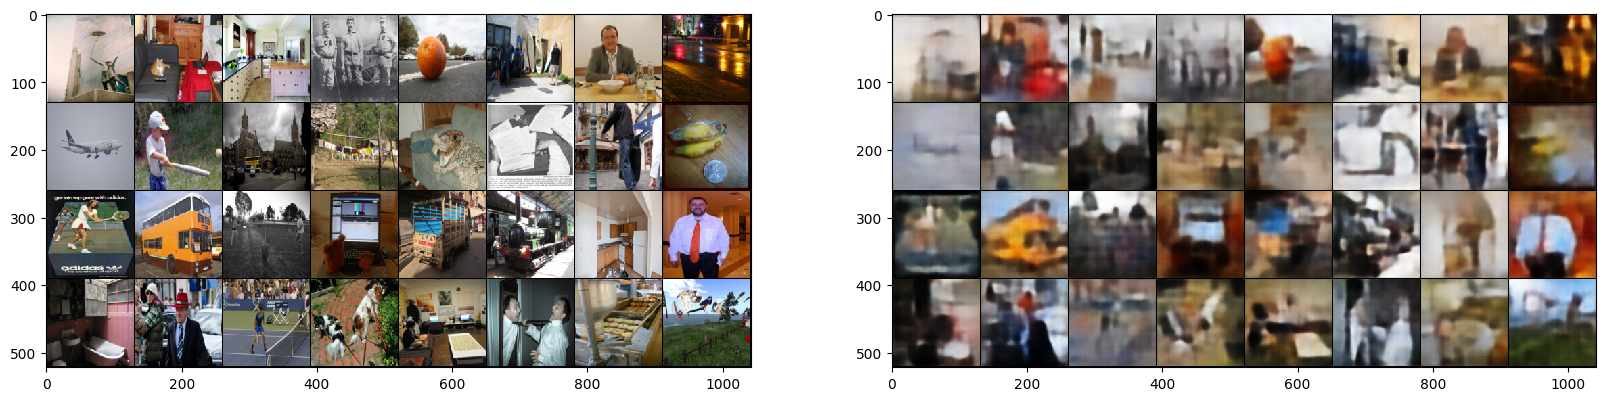

In [ ]:
# show reconstruction results
from torchvision.utils import make_grid

data, caption = next(iter(val_dataloader))
data, caption = data.to(device), caption.to(device)
reconstructed_data, _, _ = model(data, caption)

data = data[:32]
reconstructed_data = reconstructed_data[:32]

show(make_grid(data), make_grid(reconstructed_data))

## Image Generation

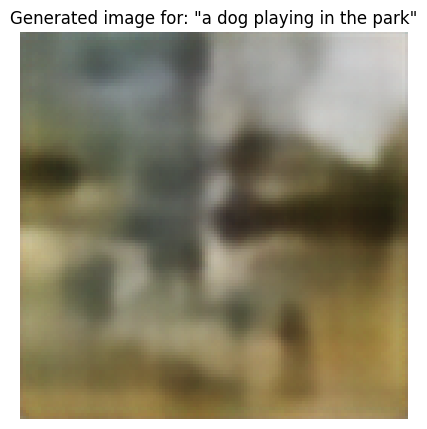

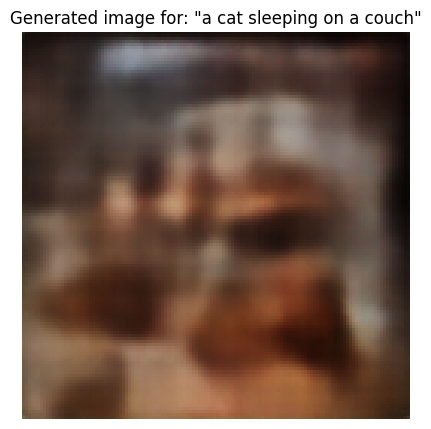

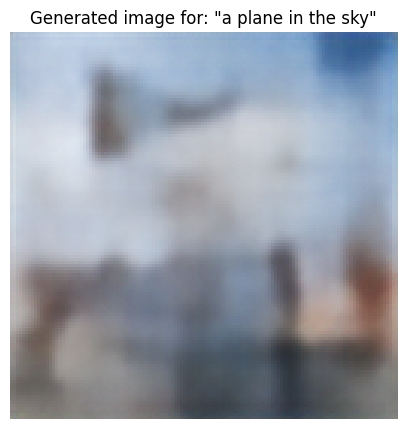

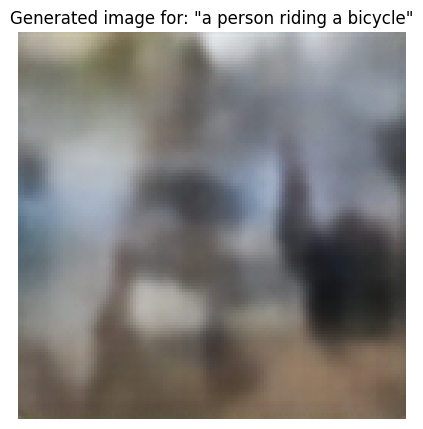

In [ ]:
# Test with different prompts
test_prompts = [
    "a dog playing in the park",
    "a cat sleeping on a couch",
    "a plane in the sky",
    "a person riding a bicycle"
]

for prompt in test_prompts:
    generate_from_text(model, prompt)

In [ ]:
torch.save(model.state_dict(), 'cvae_128_add.pt')

# CVAE 256x256 Image with Adding

## Model Architecture

In [ ]:
class cVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.clip_model, _ = clip.load("ViT-B/32", device=device)
        self.clip_model.eval()
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )

        self.flatten_size = 128 * 16 * 16

        self.condition_processor_encoder = nn.Sequential(
            nn.Linear(512, self.flatten_size)
        )

        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

        self.decoder_input = nn.Linear(latent_dim, 8 * 8 * 128)

        self.condition_processor_decoder = nn.Sequential(
            nn.Linear(512, 8 * 8 * 128)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode_condition(self, text):
        with torch.no_grad():
            embeddings = []
            for sentence in text:
                embeddings.append(self.clip_model.encode_text(clip.tokenize(sentence).to('cuda')).type(torch.float32))
            return torch.mean(torch.stack(embeddings), dim=0)

    def encode(self, x, c):
        x = self.encoder(x)
        c = self.condition_processor_encoder(c)
        x = x + c
        return self.fc_mu(x), self.fc_var(x)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        z = self.decoder_input(z)
        z = z.view(-1, 128, 8, 8)
        c = self.condition_processor_decoder(c)
        c = c.view(-1, 128, 8, 8)
        z = z + c

        return self.decoder(z)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
# model = cVAE256(latent_dim=128)
# # model.load_state_dict(torch.load('cvae_256_add.pt'))
# model.to(device)

<ipython-input-34-19c37a66c6e0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cvae_256_add.pt'))


cVAE256(
  (clip_model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizab

## Create Dataset and CLIP Feature Extractor

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = COCODatasetWithClip(
    root_dir='coco_images',
    annotation_file='/content/coco_annotations/annotations/captions_train2017.json',
    transform=transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True)

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!
Found 10000 images in directory
Loading CLIP...
Pre-encoding captions...


100%|██████████| 10000/10000 [01:40<00:00, 99.57it/s]


In [ ]:
val_dataset = COCODatasetWithClip(
    root_dir='coco_images',
    annotation_file='/content/coco_annotations/annotations/captions_val2017.json',
    transform=transform
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=True)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Found 1000 images in directory
Loading CLIP...
Pre-encoding captions...


100%|██████████| 1000/1000 [00:10<00:00, 99.75it/s]


## Model Training

In [ ]:
def train_cvae(model, train_loader, num_epochs=100, learning_rate=1e-4, device="cuda"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    train_losses = []
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (images, captions) in enumerate(pbar):
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            recon_batch, mu, log_var = model(images, captions)

            loss = loss_function(recon_batch, images, mu, log_var)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'batch_loss': loss.item()})

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        scheduler.step(avg_epoch_loss)

        print(f'====> Epoch: {epoch + 1} Average loss: {avg_epoch_loss:.4f}')

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'best_cvae_model.pth')

    return train_losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cVAE256(latent_dim=128)

losses = train_cvae(
    model=model,
    train_loader=train_dataloader,
    num_epochs=50,
    learning_rate=1e-3,
    device=device
)

Epoch 1/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.25e+6]


====> Epoch: 1 Average loss: 43099697719.7312


Epoch 2/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.17e+6]


====> Epoch: 2 Average loss: 33994360.3438


Epoch 3/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.12e+6]


====> Epoch: 3 Average loss: 33259876.5938


Epoch 4/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.11e+6]


====> Epoch: 4 Average loss: 33105823.9625


Epoch 5/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.11e+6]


====> Epoch: 5 Average loss: 33011716.3687


Epoch 6/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.1e+6]


====> Epoch: 6 Average loss: 32938146.0813


Epoch 7/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.12e+6]


====> Epoch: 7 Average loss: 32856898.0562


Epoch 8/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.1e+6]


====> Epoch: 8 Average loss: 32791442.0063


Epoch 9/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.09e+6]


====> Epoch: 9 Average loss: 32737550.8687


Epoch 10/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.11e+6]


====> Epoch: 10 Average loss: 32690941.7250


Epoch 11/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.1e+6]


====> Epoch: 11 Average loss: 32643597.5188


Epoch 12/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.06e+6]


====> Epoch: 12 Average loss: 32482543.3375


Epoch 13/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.03e+6]


====> Epoch: 13 Average loss: 32291775.2906


Epoch 14/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.07e+6]


====> Epoch: 14 Average loss: 32221857.1750


Epoch 15/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.05e+6]


====> Epoch: 15 Average loss: 32198521.0813


Epoch 16/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.09e+6]


====> Epoch: 16 Average loss: 32183153.0875


Epoch 17/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.06e+6]


====> Epoch: 17 Average loss: 32171255.9969


Epoch 18/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.01e+6]


====> Epoch: 18 Average loss: 32166544.9531


Epoch 19/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.08e+6]


====> Epoch: 19 Average loss: 32156529.9500


Epoch 20/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.05e+6]


====> Epoch: 20 Average loss: 32148405.3156


Epoch 21/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.03e+6]


====> Epoch: 21 Average loss: 32143918.4906


Epoch 22/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.09e+6]


====> Epoch: 22 Average loss: 32137996.3375


Epoch 23/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.09e+6]


====> Epoch: 23 Average loss: 32128470.4406


Epoch 24/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.09e+6]


====> Epoch: 24 Average loss: 32127703.6687


Epoch 25/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.06e+6]


====> Epoch: 25 Average loss: 32118210.3875


Epoch 26/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.09e+6]


====> Epoch: 26 Average loss: 32112929.0906


Epoch 27/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.04e+6]


====> Epoch: 27 Average loss: 32107451.4312


Epoch 28/50: 100%|██████████| 40/40 [01:16<00:00,  1.90s/it, batch_loss=2.03e+6]


====> Epoch: 28 Average loss: 32099977.7969


Epoch 29/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.03e+6]


====> Epoch: 29 Average loss: 32092436.7250


Epoch 30/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.03e+6]


====> Epoch: 30 Average loss: 32088197.5469


Epoch 31/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.06e+6]


====> Epoch: 31 Average loss: 32082513.1062


Epoch 32/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.08e+6]


====> Epoch: 32 Average loss: 32077675.1750


Epoch 33/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.04e+6]


====> Epoch: 33 Average loss: 32075035.5125


Epoch 34/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.07e+6]


====> Epoch: 34 Average loss: 32069226.6594


Epoch 35/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.03e+6]


====> Epoch: 35 Average loss: 32064952.8156


Epoch 36/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.08e+6]


====> Epoch: 36 Average loss: 32060870.3219


Epoch 37/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.07e+6]


====> Epoch: 37 Average loss: 32053657.6562


Epoch 38/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.06e+6]


====> Epoch: 38 Average loss: 32052173.3281


Epoch 39/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.09e+6]


====> Epoch: 39 Average loss: 32046747.8406


Epoch 40/50: 100%|██████████| 40/40 [01:17<00:00,  1.95s/it, batch_loss=2.04e+6]


====> Epoch: 40 Average loss: 32043375.2156


Epoch 41/50: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it, batch_loss=2.05e+6]


====> Epoch: 41 Average loss: 32041079.3938


Epoch 42/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.02e+6]


====> Epoch: 42 Average loss: 32035647.8250


Epoch 43/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.13e+6]


====> Epoch: 43 Average loss: 32031741.3313


Epoch 44/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.05e+6]


====> Epoch: 44 Average loss: 32027501.3313


Epoch 45/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.02e+6]


====> Epoch: 45 Average loss: 32026344.5094


Epoch 46/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=1.99e+6]


====> Epoch: 46 Average loss: 32023111.1781


Epoch 47/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.09e+6]


====> Epoch: 47 Average loss: 32018351.0562


Epoch 48/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.01e+6]


====> Epoch: 48 Average loss: 32017964.6094


Epoch 49/50: 100%|██████████| 40/40 [01:16<00:00,  1.92s/it, batch_loss=2.04e+6]


====> Epoch: 49 Average loss: 32016917.3188


Epoch 50/50: 100%|██████████| 40/40 [01:16<00:00,  1.91s/it, batch_loss=2.04e+6]


====> Epoch: 50 Average loss: 32012447.5969


In [ ]:
torch.save(model.state_dict(), 'cvae_256_add_new.pt')

## Metrics

In [ ]:
def compute_mse(model, data_loader):

    model.eval()
    mse_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)

            # reconstruct the data using C-VAE
            reconstructed_data, _, _ = model(data, target)


            # compute the MSE for the batch
            batch_size = data.size(0)
            batch_mse = F.mse_loss(reconstructed_data, data, reduction='sum')
            mse_loss += batch_mse.item()
            total_samples += batch_size

    # compute and return the average MSE
    average_mse = mse_loss / total_samples
    return average_mse


def compute_average_ssim(model, data_loader, image_size):
    model.eval()
    total_samples = 0
    total_ssim = 0.0

    # Initialize the SSIM metric
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # Assumes input data is in [0, 1]

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            reconstructed_data, _, _ = model(data, labels)

            data = data.view(data.size(0), 3, image_size, image_size)
            reconstructed_data = reconstructed_data.view(data.size(0), 3, image_size, image_size)

            # Compute SSIM for the batch
            batch_ssim = ssim(reconstructed_data, data)
            total_ssim += batch_ssim.item() * data.size(0)
            total_samples += data.size(0)

    # Compute average SSIM
    average_ssim = total_ssim / total_samples
    return average_ssim

In [ ]:
test_mse_256 = compute_mse(model, val_dataloader)
print(f'Test MSE: {test_mse_256:.4f}')
test_ssim_256 = compute_average_ssim(model, val_dataloader, image_size=256)
print(f'Test SSIM: {test_ssim_256:.4f}')
fid_256 = compute_fid(model, val_dataloader, image_size=256)
print(f'Test FID: {fid_256:.4f}')

Test MSE: 20618.0745
Test SSIM: 0.1656
Test FID: 243.7546


## Reconstruction

In [ ]:
truth = []
predicted = []
with torch.no_grad():
    for data, labels in val_dataloader:
        data, labels = data.to(device), labels.to(device)

        #  process input
        reconstructed_data, _, _ = model(data, labels)

        # Reshape to image format for SSIM computation
        data = data.view(data.size(0), 3, 256, 256)  # (batch_size, channels, height, width)
        reconstructed_data = reconstructed_data.view(data.size(0), 3, 256, 256)
        truth.append(data)
        predicted.append(reconstructed_data)

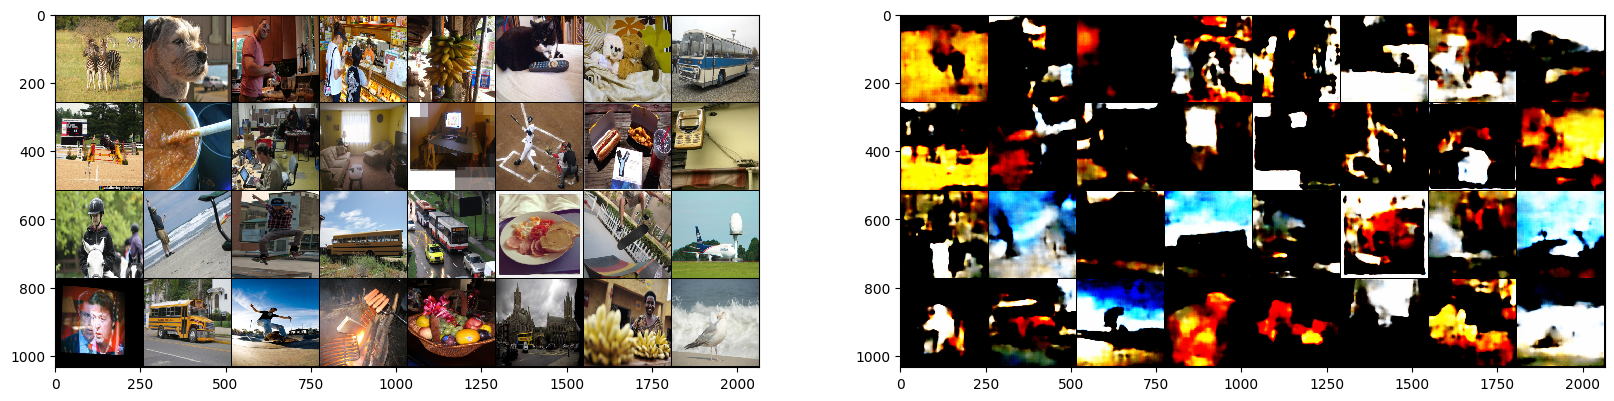

In [ ]:
# show reconstruction results

data, caption = next(iter(val_dataloader))
data, caption = data.to(device), caption.to(device)
reconstructed_data, _, _ = model(data, caption)

data = data[:32]
reconstructed_data = reconstructed_data[:32]

if reconstructed_data.min() < 0 or reconstructed_data.max() > 1:
    reconstructed_data = (reconstructed_data - reconstructed_data.min()) / (reconstructed_data.max() - reconstructed_data.min())

show(make_grid(data), make_grid(reconstructed_data))

## Image Generation

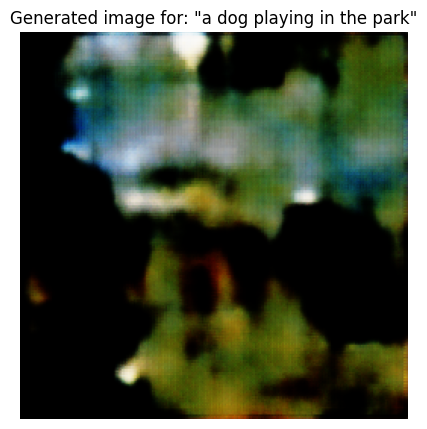

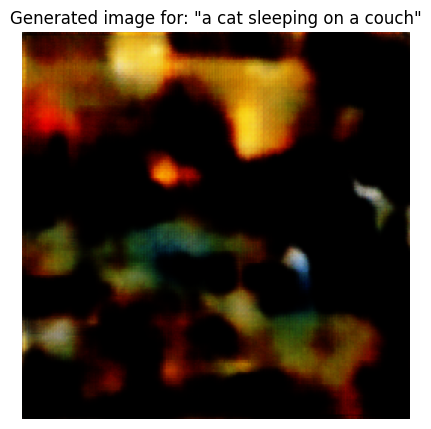

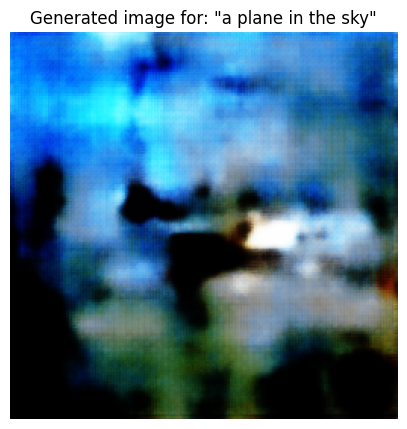

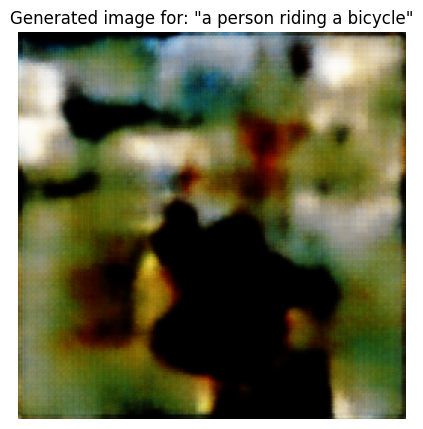

In [ ]:
# Test with different prompts
test_prompts = [
    "a dog playing in the park",
    "a cat sleeping on a couch",
    "a plane in the sky",
    "a person riding a bicycle"
]

for prompt in test_prompts:
    generate_from_text(model, prompt)

# For 64x64 Adding

*This is already done in 64x64 model architecture notebook this was just another training run

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = COCODatasetWithClip(
    root_dir='coco_images',
    annotation_file='/content/coco_annotations/annotations/captions_train2017.json',
    transform=transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True)

loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
Found 10000 images in directory
Loading CLIP...
Pre-encoding captions...


100%|██████████| 10000/10000 [01:43<00:00, 96.48it/s]


In [ ]:
val_dataset = COCODatasetWithClip(
    root_dir='coco_images',
    annotation_file='/content/coco_annotations/annotations/captions_val2017.json',
    transform=transform
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=True)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Found 1000 images in directory
Loading CLIP...
Pre-encoding captions...


100%|██████████| 1000/1000 [00:10<00:00, 98.90it/s]


In [ ]:
class CVAE64(nn.Module):
    def __init__(self, text_embedding_dim=512, latent_dim=256, image_channels=3, image_size=64):
        """
        Args:
            text_embedding_dim (int): Dimension of text embeddings.
            latent_dim (int): Dimension of latent space.
            image_channels (int): Number of channels in the output image.
            image_size (int): Size (height and width) of the generated images (assumes square images).
        """
        super().__init__()
        self.text_embedding_dim = text_embedding_dim
        self.latent_dim = latent_dim
        self.image_channels = image_channels
        self.image_size = image_size

        #### for 64x64 images
        # Encoder:
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()
        )

        self.text_processor_encoder = nn.Linear(text_embedding_dim, 256 * (image_size // 8) ** 2)

        self.latent_processor = nn.Linear(256 * (image_size // 8) ** 2, 1024)
        self.mu = nn.Linear(1024, latent_dim)
        self.logvar = nn.Linear(1024, latent_dim)

        # Decoder:
        self.decoder_input = nn.Linear(latent_dim, 256 * (image_size // 8) ** 2)
        self.text_processor_decoder = nn.Linear(text_embedding_dim, 256 * (image_size // 8) ** 2)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, image_channels, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Tanh()  # Outputs normalized to [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + sigma * epsilon."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, images, text_embedding):
        """Encoder forward pass."""
        image_features = self.encoder(images)
        processed_text = self.text_processor_encoder(text_embedding)
        combined_features = image_features + processed_text
        latent_space = self.latent_processor(combined_features)
        mu = self.mu(latent_space)
        logvar = self.logvar(latent_space)

        return mu, logvar

    def decode(self, z, text_embedding):
        """Decoder forward pass."""
        z_processed = self.decoder_input(z)
        text_processed = self.text_processor_decoder(text_embedding)
        decoder_input = z_processed + text_processed
        batch_size_dynamic = decoder_input.size(0)
        decoder_input = decoder_input.view(batch_size_dynamic, 256, self.image_size // 8, self.image_size // 8)
        reconstructed_images = self.decoder(decoder_input)
        return reconstructed_images

    def forward(self, images, text_embedding):
        """
        Forward pass through the cVAE.
        Args:
            text_embedding (torch.Tensor): Text embeddings of shape (batch_size, text_embedding_dim).
            images (torch.Tensor, optional): Ground-truth images of shape (batch_size, image_channels, image_size, image_size).
        Returns:
            reconstructed_images (torch.Tensor): Generated images.
            mu (torch.Tensor): Mean of latent distribution.
            logvar (torch.Tensor): Log variance of latent distribution.
        """
        mu, logvar = self.encode(images, text_embedding)
        z = self.reparameterize(mu, logvar)
        reconstructed_images = self.decode(z, text_embedding)
        return reconstructed_images, mu, logvar

In [ ]:
model = CVAE64(latent_dim=256)

In [ ]:
def loss_function(recon_x, x, mu, logvar):
   """Computes the loss = -ELBO = Negative Log-Likelihood + KL Divergence.

   Args:
       recon_x: Decoder output.
       x: Ground truth.
       mu: Mean of Z
       logvar: Log-Variance of Z

   Returns:
       loss (torch.Tensor): Total loss (reconstruction + KL divergence).
   """
   # BCE as Negative Log-likelihood as data is normalized to range [0,1]
   #BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
   # Alternative: L2 reconstruction error (MSE as the negative log-likelihood term for Gaussian likelihood)
   MSE = F.mse_loss(recon_x, x, reduction='sum')
   KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
   #return BCE + KLD
   return MSE + KLD

In [ ]:
def train_cvae(model, train_loader, num_epochs=100, learning_rate=1e-4, device="cuda"):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    train_losses = []
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (images, captions) in enumerate(pbar):
            images = images.to(device)
            captions = captions.to(device)

            optimizer.zero_grad()

            recon_batch, mu, log_var = model(images, captions)

            loss = loss_function(recon_batch, images, mu, log_var)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({'batch_loss': loss.item()})

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        scheduler.step(avg_epoch_loss)

        print(f'====> Epoch: {epoch + 1} Average loss: {avg_epoch_loss:.4f}')

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'best_cvae_64_model.pth')

    return train_losses

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cVAE64(latent_dim=256)

losses = train_cvae(
    model=model,
    train_loader=train_dataloader,
    num_epochs=50,
    learning_rate=1e-3,
    device=device
)

Epoch 1/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=5.75e+3]


====> Epoch: 1 Average loss: 159910.2523


Epoch 2/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=6.4e+3]


====> Epoch: 2 Average loss: 105036.7834


Epoch 3/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=6.11e+3]


====> Epoch: 3 Average loss: 93906.8708


Epoch 4/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.97e+3]


====> Epoch: 4 Average loss: 87703.4698


Epoch 5/50: 100%|██████████| 40/40 [00:51<00:00,  1.30s/it, batch_loss=4.72e+3]


====> Epoch: 5 Average loss: 83542.2276


Epoch 6/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=5e+3]


====> Epoch: 6 Average loss: 79992.7967


Epoch 7/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=5.53e+3]


====> Epoch: 7 Average loss: 77085.1449


Epoch 8/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=5.57e+3]


====> Epoch: 8 Average loss: 75075.9252


Epoch 9/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.35e+3]


====> Epoch: 9 Average loss: 73091.7279


Epoch 10/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.4e+3]


====> Epoch: 10 Average loss: 71819.2734


Epoch 11/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.59e+3]


====> Epoch: 11 Average loss: 70849.6890


Epoch 12/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.03e+3]


====> Epoch: 12 Average loss: 69738.1291


Epoch 13/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.46e+3]


====> Epoch: 13 Average loss: 69195.1472


Epoch 14/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=5.24e+3]


====> Epoch: 14 Average loss: 68723.0595


Epoch 15/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.83e+3]


====> Epoch: 15 Average loss: 68025.7613


Epoch 16/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.48e+3]


====> Epoch: 16 Average loss: 67869.3731


Epoch 17/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=5.13e+3]


====> Epoch: 17 Average loss: 67181.3171


Epoch 18/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=5.85e+3]


====> Epoch: 18 Average loss: 67204.1425


Epoch 19/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.77e+3]


====> Epoch: 19 Average loss: 66595.1784


Epoch 20/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.82e+3]


====> Epoch: 20 Average loss: 66448.1462


Epoch 21/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.35e+3]


====> Epoch: 21 Average loss: 66056.1544


Epoch 22/50: 100%|██████████| 40/40 [00:51<00:00,  1.30s/it, batch_loss=4.42e+3]


====> Epoch: 22 Average loss: 66059.8716


Epoch 23/50: 100%|██████████| 40/40 [00:51<00:00,  1.30s/it, batch_loss=4.29e+3]


====> Epoch: 23 Average loss: 65669.0362


Epoch 24/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.19e+3]


====> Epoch: 24 Average loss: 65440.3242


Epoch 25/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.31e+3]


====> Epoch: 25 Average loss: 65321.2750


Epoch 26/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.34e+3]


====> Epoch: 26 Average loss: 64944.5878


Epoch 27/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=4.25e+3]


====> Epoch: 27 Average loss: 65129.7290


Epoch 28/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.54e+3]


====> Epoch: 28 Average loss: 64667.7490


Epoch 29/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.41e+3]


====> Epoch: 29 Average loss: 64453.8450


Epoch 30/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.57e+3]


====> Epoch: 30 Average loss: 64371.7388


Epoch 31/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=3.67e+3]


====> Epoch: 31 Average loss: 64291.5483


Epoch 32/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.41e+3]


====> Epoch: 32 Average loss: 64137.2116


Epoch 33/50: 100%|██████████| 40/40 [00:51<00:00,  1.30s/it, batch_loss=4e+3]


====> Epoch: 33 Average loss: 64047.3683


Epoch 34/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.44e+3]


====> Epoch: 34 Average loss: 63840.8114


Epoch 35/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.93e+3]


====> Epoch: 35 Average loss: 63788.9223


Epoch 36/50: 100%|██████████| 40/40 [00:51<00:00,  1.30s/it, batch_loss=4.62e+3]


====> Epoch: 36 Average loss: 63395.1633


Epoch 37/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.4e+3]


====> Epoch: 37 Average loss: 63489.6561


Epoch 38/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.39e+3]


====> Epoch: 38 Average loss: 63296.0012


Epoch 39/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=3.85e+3]


====> Epoch: 39 Average loss: 63087.5010


Epoch 40/50: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it, batch_loss=3.9e+3]


====> Epoch: 40 Average loss: 63093.5061


Epoch 41/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=5e+3]


====> Epoch: 41 Average loss: 63072.0389


Epoch 42/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=3.89e+3]


====> Epoch: 42 Average loss: 62834.7637


Epoch 43/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.29e+3]


====> Epoch: 43 Average loss: 62750.1332


Epoch 44/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=3.94e+3]


====> Epoch: 44 Average loss: 62497.9720


Epoch 45/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.11e+3]


====> Epoch: 45 Average loss: 62540.0015


Epoch 46/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=5.68e+3]


====> Epoch: 46 Average loss: 62324.7541


Epoch 47/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=4.25e+3]


====> Epoch: 47 Average loss: 62156.2937


Epoch 48/50: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it, batch_loss=5.15e+3]


====> Epoch: 48 Average loss: 62119.7010


Epoch 49/50: 100%|██████████| 40/40 [00:52<00:00,  1.30s/it, batch_loss=3.75e+3]


====> Epoch: 49 Average loss: 62100.3859


Epoch 50/50: 100%|██████████| 40/40 [00:52<00:00,  1.30s/it, batch_loss=3.47e+3]


====> Epoch: 50 Average loss: 61901.7653


In [ ]:
test_mse_64 = compute_mse(model, val_dataloader)
print(f'Test MSE: {test_mse_64:.4f}')
test_ssim_64 = compute_average_ssim(model, val_dataloader, image_size=64)
print(f'Test SSIM: {test_ssim_64:.4f}')
# fid_64 = compute_fid(model, val_dataloader, image_size=64)
# print(f'Test FID: {fid_64:.4f}')

Test MSE: 195.2407
Test SSIM: 0.4135


In [ ]:
truth = []
predicted = []
with torch.no_grad():
    for data, labels in val_dataloader:
        data, labels = data.to(device), labels.to(device)

        #  process input
        reconstructed_data, _, _ = model(data, labels)

        # Reshape to image format for SSIM computation
        data = data.view(data.size(0), 3, 64, 64)  # (batch_size, channels, height, width)
        reconstructed_data = reconstructed_data.view(data.size(0), 3, 64, 64)
        truth.append(data)
        predicted.append(reconstructed_data)

In [ ]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()

    fig, axes = plt.subplots(1,2, figsize=(20, 10))
    axes[0].imshow(np.transpose(npimg1, (1, 2, 0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1, 2, 0)), interpolation='nearest')

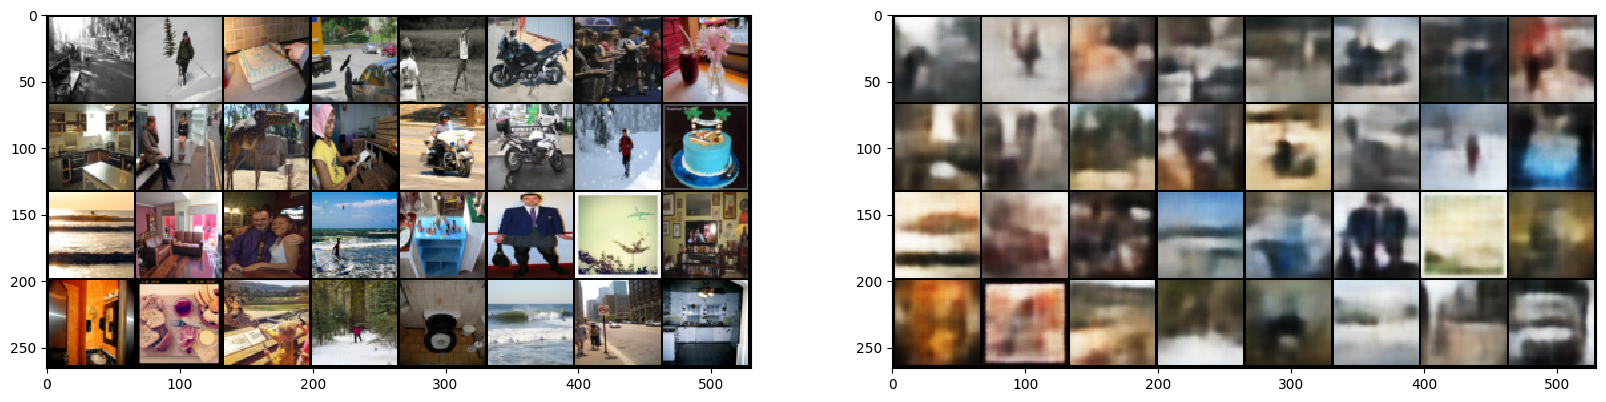

In [ ]:
# show reconstruction results
from torchvision.utils import make_grid

data, caption = next(iter(val_dataloader))
data, caption = data.to(device), caption.to(device)
reconstructed_data, _, _ = model(data, caption)

data = data[:32]
reconstructed_data = reconstructed_data[:32]

show(make_grid(data), make_grid(reconstructed_data))

In [ ]:
torch.save(model.state_dict(), 'cvae_64_add_new.pt')

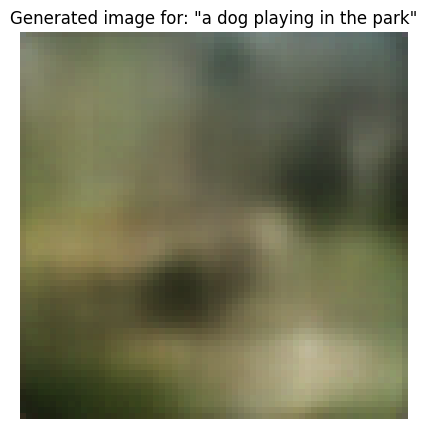

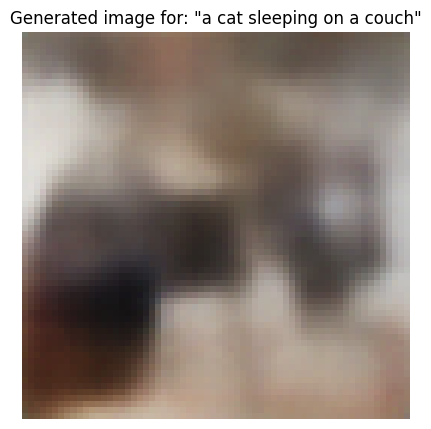

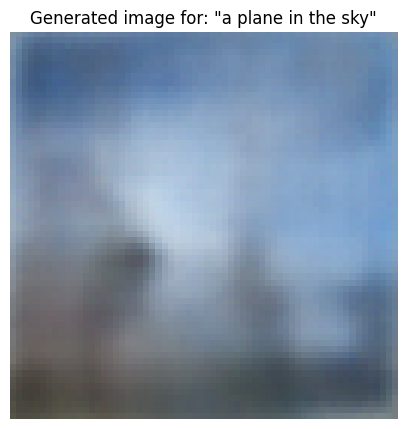

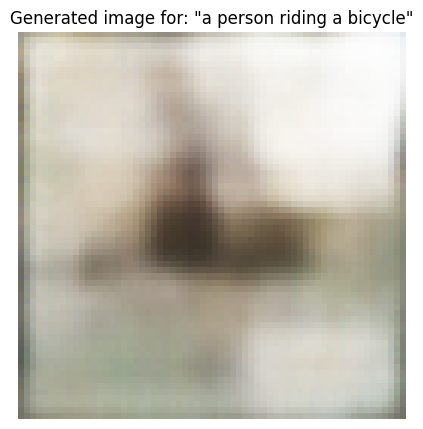

In [ ]:
# Test with different prompts
test_prompts = [
    "a dog playing in the park",
    "a cat sleeping on a couch",
    "a plane in the sky",
    "a person riding a bicycle"
]

for prompt in test_prompts:
    generate_from_text(model, prompt)